---
layout: post  
---

In [12]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
        # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

  Resolving package versions...
┌ Info: Precompiling Eisenia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1278
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Res

In [62]:
n_sequences = 2^0

1

In [63]:
seqlen = 10^1

10

In [64]:
n_observations = 10^2

100

In [89]:
sequences = [BioSequences.randdnaseq(Random.seed!(i), seqlen) for i in 1:n_sequences]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCGTCCCAGG

In [90]:
error_rate = 0.05

0.05

In [79]:
function my_isequal(a, b)
    return (a == b) || (BioSequences.reverse_complement(a) == b)
end

my_isequal (generic function with 1 method)

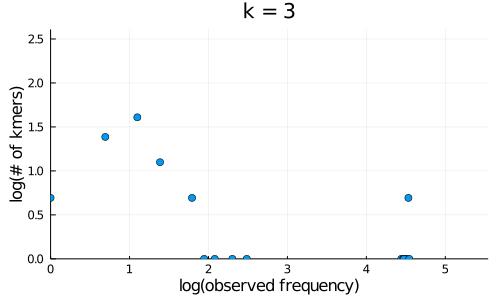

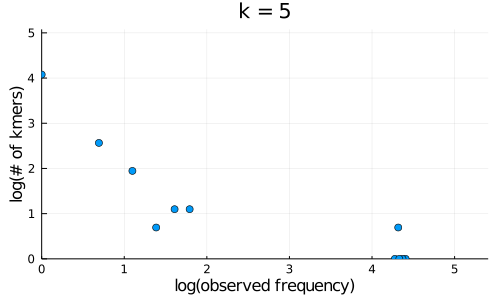

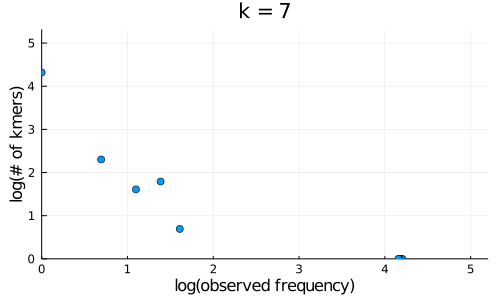

In [80]:
for k in Primes.primes(3, min(seqlen, 31))
    counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
    display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
end

These all seem fine, let's see what the graphs look like for each

In [96]:
function assess_observations(graph::Eisenia.KmerGraph{KMER_TYPE}, observations, error_rate) where {KMER_TYPE}
    k = last(KMER_TYPE.parameters)
    total_edits_accepted = 0
    total_bases_evaluated = 0
    reads_processed = 0
    maximum_likelihood_observations = Vector{BioSequences.LongDNASeq}(undef, length(observations))
    for (observation_index, observation) in enumerate(observations)
        if length(observation) >= k
            optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
            maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
            maximum_likelihood_observations[observation_index] = maximum_likelihood_observation
            reads_processed += 1
            total_bases_evaluated += length(observation)
            total_edits_accepted += edit_distance
        else
            maximum_likelihood_observations[observation_index] = observation
        end
    end
    inferred_error_rate = round(total_edits_accepted / total_bases_evaluated, digits = 3)
    @info "reads_processed = $(reads_processed)"
    @info "total_edits_accepted = $(total_edits_accepted)"
    @info "inferred_error_rate = $(inferred_error_rate)"
    if total_edits_accepted == 0
        has_converged = true
    else
        has_converged = false
    end
    return maximum_likelihood_observations, has_converged
end

assess_observations (generic function with 1 method)

In [97]:
function iterate_until_convergence(k, observations, error_rate)
    current_round = 1
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
    display(Eisenia.plot_graph(graph))
    has_converged = false
    while !has_converged
        observations, has_converged = assess_observations(graph, observations, error_rate)
        @info "round $current_round complete"
        current_round += 1
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
    display(Eisenia.plot_graph(graph))
    return observations
end

iterate_until_convergence (generic function with 1 method)

In [113]:
function iterative_assembly(ks, observations, error_rate)
    for k in ks
        graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
        display(Eisenia.plot_graph(graph))
        observations, has_converged = assess_observations(graph, observations, error_rate)
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{last(ks)}, observations)
    display(Eisenia.plot_graph(graph))
    return observations
end

iterative_assembly (generic function with 2 methods)

In [114]:
Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) for i in 1:n_observations
]

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGATCGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCAGG
 TGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACCA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGCG
 TCGTCCCATG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGCGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCACGTCCCGAGG
 CCTGGGACGA
 TCGCTCCCAGG

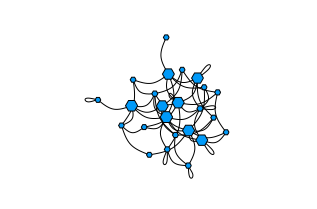

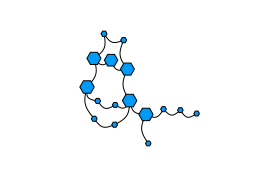

┌ Info: reads_processed = 100
└ @ Main In[96]:20
┌ Info: total_edits_accepted = 37
└ @ Main In[96]:21
┌ Info: inferred_error_rate = 0.037
└ @ Main In[96]:22
┌ Info: reads_processed = 100
└ @ Main In[96]:20


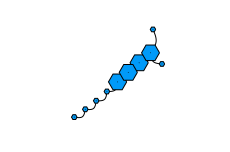

┌ Info: total_edits_accepted = 17
└ @ Main In[96]:21
┌ Info: inferred_error_rate = 0.017
└ @ Main In[96]:22


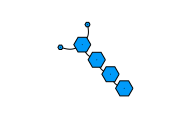

┌ Info: reads_processed = 100
└ @ Main In[96]:20
┌ Info: total_edits_accepted = 9
└ @ Main In[96]:21
┌ Info: inferred_error_rate = 0.009
└ @ Main In[96]:22


100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 CGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCCCAGG
 CCTGGGACGA
 TCGTCCCAGG

In [122]:
Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) for i in 1:n_observations
]
observations = iterative_assembly(Primes.primes(3, 7), observations, error_rate)

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
# k = 3
# graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:

maximum_likelihood_observations = BioSequences.LongDNASeq[]
for observation in observations
    if length(observation) >= k
        total_bases_evaluated += length(observation)
        optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
        total_edits_accepted += edit_distance
        maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
        was_equal_before = my_isequal(observation, first(sequences))
        if !was_equal_before
            @show my_isequal(maximum_likelihood_observation, first(sequences))
        end
        push!(maximum_likelihood_observations, maximum_likelihood_observation)
    end
end

In [ ]:
# total_edits_accepted / total_bases_evaluated

In [ ]:
# maximum_likelihood_observations

In [ ]:
# observations = maximum_likelihood_observations
# maximum_likelihood_observations = BioSequences.LongDNASeq[]

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
#     display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
# end

These all seem fine, let's see what the graphs look like for each

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
#     display(Eisenia.plot_graph(graph))
# end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
# k = 3
# graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
# total_edits_accepted = 0
# total_bases_evaluated = 0

In [ ]:
# for observation in observations
#     if length(observation) >= k
#         total_bases_evaluated += length(observation)
#         optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
#         total_edits_accepted += edit_distance
#         maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
#         was_equal_before = my_isequal(observation, first(sequences))
#         if !was_equal_before
#             @show my_isequal(maximum_likelihood_observation, first(sequences))
#         end
#         push!(maximum_likelihood_observations, maximum_likelihood_observation)
#     end
# end

In [ ]:
# total_edits_accepted / total_bases_evaluated

In [ ]:
# observations = maximum_likelihood_observations
# maximum_likelihood_observations = BioSequences.LongDNASeq[]

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
#     display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
# end

These all seem fine, let's see what the graphs look like for each

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
#     display(Eisenia.plot_graph(graph))
# end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
# k = 3
# graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
# total_edits_accepted = 0
# total_bases_evaluated = 0

In [ ]:
# for observation in observations
#     if length(observation) >= k
#         total_bases_evaluated += length(observation)
#         optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
#         total_edits_accepted += edit_distance
#         maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
#         was_equal_before = my_isequal(observation, first(sequences))
#         if !was_equal_before
#             @show my_isequal(maximum_likelihood_observation, first(sequences))
#         end
#         push!(maximum_likelihood_observations, maximum_likelihood_observation)
#     end
# end

In [ ]:
# total_edits_accepted / total_bases_evaluated

In [ ]:
# observations = maximum_likelihood_observations
# maximum_likelihood_observations = BioSequences.LongDNASeq[]

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
#     display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
# end

These all seem fine, let's see what the graphs look like for each

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
#     display(Eisenia.plot_graph(graph))
# end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
# k = 5
# graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
# total_edits_accepted = 0
# total_bases_evaluated = 0

In [ ]:
# maximum_likelihood_observations = BioSequences.LongDNASeq[]
# for observation in observations
#     if length(observation) >= k
#         total_bases_evaluated += length(observation)
#         optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
#         total_edits_accepted += edit_distance
#         maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
#         was_equal_before = my_isequal(observation, first(sequences))
#         if !was_equal_before
#             @show my_isequal(maximum_likelihood_observation, first(sequences))
#         end
#         push!(maximum_likelihood_observations, maximum_likelihood_observation)
#     end
# end

In [ ]:
# total_edits_accepted / total_bases_evaluated

In [ ]:
# observations = maximum_likelihood_observations

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
#     display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
# end

These all seem fine, let's see what the graphs look like for each

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
#     display(Eisenia.plot_graph(graph))
# end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
# k = 5
# graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
# total_edits_accepted = 0
# total_bases_evaluated = 0

In [ ]:
# maximum_likelihood_observations = BioSequences.LongDNASeq[]
# for observation in observations
#     if length(observation) >= k
#         total_bases_evaluated += length(observation)
#         optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
#         total_edits_accepted += edit_distance
#         maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
#         was_equal_before = my_isequal(observation, first(sequences))
#         if !was_equal_before
#             @show my_isequal(maximum_likelihood_observation, first(sequences))
#         end
#         push!(maximum_likelihood_observations, maximum_likelihood_observation)
#     end
# end

In [ ]:
# total_edits_accepted / total_bases_evaluated

In [ ]:
# observations = maximum_likelihood_observations
# maximum_likelihood_observations = BioSequences.LongDNASeq[]

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
#     display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
# end

These all seem fine, let's see what the graphs look like for each

In [ ]:
# for k in Primes.primes(3, min(seqlen, 31))
#     graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
#     display(Eisenia.plot_graph(graph))
# end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
k = 7
graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
total_edits_accepted = 0
total_bases_evaluated = 0

In [ ]:
observations

In [ ]:
maximum_likelihood_observations = BioSequences.LongDNASeq[]
for observation in observations
    if length(observation) >= k
        total_bases_evaluated += length(observation)
        optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
        total_edits_accepted += edit_distance
        maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
        was_equal_before = my_isequal(observation, first(sequences))
        if !was_equal_before
            @show my_isequal(maximum_likelihood_observation, first(sequences))
        end
        push!(maximum_likelihood_observations, maximum_likelihood_observation)
    end
end

In [ ]:
total_edits_accepted / total_bases_evaluated

In [ ]:
observations = maximum_likelihood_observations

In [ ]:
for k in Primes.primes(3, min(seqlen, 31))
    counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
    display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
end

These all seem fine, let's see what the graphs look like for each

In [ ]:
for k in Primes.primes(3, min(seqlen, 31))
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
    display(Eisenia.plot_graph(graph))
end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal

In [ ]:
k = 7
graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)

In [ ]:
total_edits_accepted = 0
total_bases_evaluated = 0

In [ ]:
maximum_likelihood_observations = BioSequences.LongDNASeq[]
for observation in observations
    if length(observation) >= k
        total_bases_evaluated += length(observation)
        optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
        total_edits_accepted += edit_distance
        maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
        was_equal_before = my_isequal(observation, first(sequences))
        if !was_equal_before
            @show my_isequal(maximum_likelihood_observation, first(sequences))
        end
        push!(maximum_likelihood_observations, maximum_likelihood_observation)
    end
end

In [ ]:
total_edits_accepted / total_bases_evaluated

In [ ]:
observations = maximum_likelihood_observations
maximum_likelihood_observations = BioSequences.LongDNASeq[]

In [ ]:
for k in Primes.primes(3, min(seqlen, 31))
    counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
    display(Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300)))
end

These all seem fine, let's see what the graphs look like for each

In [ ]:
for k in Primes.primes(3, min(seqlen, 31))
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
    display(Eisenia.plot_graph(graph))
end

Let's go with k = 3. k = 5 seems like it has lots of disjointed tips and k=7 fragments the graphs to the point that there are no overlaps. This suggests that the smallest possible k that can separate signal from noise is ideal